# Load Imports

In [1]:
# @title Load the imports

import io
import keras
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import plotly.express as px
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 10
pd.options.display.float_format = "{:.1f}".format

print("Ran the import statements.")

Mounted at /content/drive
Ran the import statements.


In [5]:
# @title Load the dataset
rice_dataset_raw = pd.read_excel("/content/drive/MyDrive/Rice_Cammeo_Osmancik.xlsx")
rice_dataset_raw.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class
0,15231,525.6,229.7,85.1,0.9,15617,0.6,Cammeo
1,14656,494.3,206.0,91.7,0.9,15072,0.6,Cammeo
2,14634,501.1,214.1,87.8,0.9,14954,0.7,Cammeo
3,13176,458.3,193.3,87.4,0.9,13368,0.6,Cammeo
4,14688,507.2,211.7,89.3,0.9,15262,0.6,Cammeo


Once the dataset has been loaded via the cell above, select specific columns to show summary statistics of the numerical features in the dataset.



In [7]:
# @title
# Read and provide statistics on the dataset.
rice_dataset = rice_dataset_raw[[
    'Area',
    'Perimeter',
    'Major_Axis_Length',
    'Minor_Axis_Length',
    'Eccentricity',
    'Convex_Area',
    'Extent',
    'Class',
]]

rice_dataset.describe()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent
count,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0,3810.0
mean,12667.7,454.2,188.8,86.3,0.9,12952.5,0.7
std,1732.4,35.6,17.4,5.7,0.0,1777.0,0.1
min,7551.0,359.1,145.3,59.5,0.8,7723.0,0.5
25%,11370.5,426.1,174.4,82.7,0.9,11626.2,0.6
50%,12421.5,448.9,185.8,86.4,0.9,12706.5,0.6
75%,13950.0,483.7,203.6,90.1,0.9,14284.0,0.7
max,18913.0,548.4,239.0,107.5,0.9,19099.0,0.9


# Explore the dataset

Plot some of the features against each other, including in 3D.


In [8]:
# Create five 2D plots of the features against each other, color-coded by class.
for x_axis_data, y_axis_data in [
    ('Area', 'Eccentricity'),
    ('Convex_Area', 'Perimeter'),
    ('Major_Axis_Length', 'Minor_Axis_Length'),
    ('Perimeter', 'Extent'),
    ('Eccentricity', 'Major_Axis_Length'),
]:
  px.scatter(rice_dataset, x=x_axis_data, y=y_axis_data, color='Class').show()

## Normalize data

wenormalize the numerical values in the rice dataset by converting them to Z-scores.

In [9]:
# Calculate the Z-scores of each numerical column in the raw data and write
# them into a new DataFrame named df_norm.

feature_mean = rice_dataset.mean(numeric_only=True)
feature_std = rice_dataset.std(numeric_only=True)
numerical_features = rice_dataset.select_dtypes('number').columns
normalized_dataset = (
    rice_dataset[numerical_features] - feature_mean
) / feature_std

# Copy the class to the new dataframe
normalized_dataset['Class'] = rice_dataset['Class']


# Set the random seeds



In [10]:
keras.utils.set_random_seed(42)

## Label and split data

To train the model, we'll arbritrarily assign the Cammeo species a label of '1' and the Osmancik species a label of '0'.

In [11]:
# Create a column setting the Cammeo label to '1' and the Osmancik label to '0'
# then show 10 randomly selected rows.
normalized_dataset['Class_Bool'] = (
    # Returns true if class is Cammeo, and false if class is Osmancik
    normalized_dataset['Class'] == 'Cammeo'
).astype(int)
normalized_dataset.sample(10)

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
1011,-0.1,0.1,-0.1,0.2,-0.1,-0.0,-1.0,Cammeo,1
3185,-0.1,-0.5,-0.5,0.4,-0.8,-0.2,-0.3,Osmancik,0
3698,0.1,-0.1,-0.4,0.9,-1.1,0.1,-0.2,Osmancik,0
897,0.2,0.5,0.8,-0.5,1.2,0.2,1.5,Cammeo,1
3245,-1.3,-1.3,-0.9,-1.6,0.5,-1.4,-1.1,Osmancik,0
478,0.2,0.2,0.4,-0.0,0.5,0.2,1.7,Cammeo,1
1731,-0.4,-0.8,-0.8,0.3,-1.0,-0.5,-0.4,Osmancik,0
1025,0.6,0.7,0.6,0.3,0.5,0.6,-0.5,Cammeo,1
429,1.2,1.2,1.4,0.6,1.0,1.2,1.8,Cammeo,1
1330,-0.4,-0.0,0.4,-1.3,1.4,-0.5,-0.1,Cammeo,1


We can then randomize and partition the dataset into train, test, and validation splits, consisting of 80%, 10%, and 10% of the dataset respectively.

In [12]:
# Create indices at the 80th and 90th percentiles
number_samples = len(normalized_dataset)
index_80th = round(number_samples * 0.8)
index_90th = index_80th + round(number_samples * 0.1)

# Randomize order and split into train, validation, and test with a .8, .1, .1 split
shuffled_dataset = normalized_dataset.sample(frac=1, random_state=100)
train_data = shuffled_dataset.iloc[0:index_80th]
validation_data = shuffled_dataset.iloc[index_80th:index_90th]
test_data = shuffled_dataset.iloc[index_90th:]

# Show the first five rows of the last split
test_data.head()

,Area,Perimeter,Major_Axis_Length,Minor_Axis_Length,Eccentricity,Convex_Area,Extent,Class,Class_Bool
2405,-0.4,-0.7,-0.8,0.3,-1.1,-0.4,0.3,Osmancik,0
3062,-0.2,-0.0,0.2,-0.7,0.8,-0.2,1.6,Osmancik,0
1155,1.4,1.2,1.1,1.2,0.3,1.3,0.7,Cammeo,1
660,1.2,1.0,0.8,1.3,-0.0,1.2,-0.6,Cammeo,1
2451,-1.2,-1.2,-1.4,-0.3,-1.5,-1.1,0.1,Osmancik,0


It's important to prevent the model from getting the label as input during training, which is called label leakage. This can be done by storing features and labels as separate variables.

In [13]:
label_columns = ['Class', 'Class_Bool']

train_features = train_data.drop(columns=label_columns)
train_labels = train_data['Class_Bool'].to_numpy()
validation_features = validation_data.drop(columns=label_columns)
validation_labels = validation_data['Class_Bool'].to_numpy()
test_features = test_data.drop(columns=label_columns)
test_labels = test_data['Class_Bool'].to_numpy()

## Train the model

### Choose the input features

To start with, we'll train a model on `Eccentricity`, `Major_Axis_Length,` and `Area`.

In [14]:
# Name of the features we'll train our model on.
input_features = [
    'Eccentricity',
    'Major_Axis_Length',
    'Area',
]

## Define functions that build and train a model

The following code cell defines two functions:

  * `create_model(inputs, learning_rate, metrics)`, which defines the model's architecture.
  * `train_model(model, dataset, epochs, label_name, batch_size, shuffle)`, uses input features and labels to train the model.

Note: create_model applies the sigmoid function to perform [logistic regression](https://developers.google.com/machine-learning/crash-course/logistic-regression).

We also define two helpful data structures: `ExperimentSettings` and `Experiment`. We use these simple classes to keep track of our experiments, allowing us to know what hyperparameters were used and what the results were. In `ExperimentSettings`, we store all values describing an experiment (i.e., hyperparameters). Then, we store the results of a training run (i.e., the model and the training metrics) into an `Experiment` instance, along with the `ExperimentSettings` used for that experiment.

In [16]:
# @title Define the functions that create and train a model.

import dataclasses


@dataclasses.dataclass()
class ExperimentSettings:
  """Lists the hyperparameters and input features used to train am model."""

  learning_rate: float
  number_epochs: int
  batch_size: int
  classification_threshold: float
  input_features: list[str]


@dataclasses.dataclass()
class Experiment:
  """Stores the settings used for a training run and the resulting model."""

  name: str
  settings: ExperimentSettings
  model: keras.Model
  epochs: np.ndarray
  metrics_history: keras.callbacks.History

  def get_final_metric_value(self, metric_name: str) -> float:
    """Gets the final value of the given metric for this experiment."""
    if metric_name not in self.metrics_history:
      raise ValueError(
          f'Unknown metric {metric_name}: available metrics are'
          f' {list(self.metrics_history.columns)}'
      )
    return self.metrics_history[metric_name].iloc[-1]


def create_model(
    settings: ExperimentSettings,
    metrics: list[keras.metrics.Metric],
) -> keras.Model:
  """Create and compile a simple classification model."""
  model_inputs = [
      keras.Input(name=feature, shape=(1,))
      for feature in settings.input_features
  ]
  # Use a Concatenate layer to assemble the different inputs into a single
  # tensor which will be given as input to the Dense layer.
  # For example: [input_1[0][0], input_2[0][0]]

  concatenated_inputs = keras.layers.Concatenate()(model_inputs)
  dense = keras.layers.Dense(
      units=1, input_shape=(1,), name='dense_layer', activation=keras.activations.sigmoid
  )
  model_output = dense(concatenated_inputs)
  model = keras.Model(inputs=model_inputs, outputs=model_output)
  # Call the compile method to transform the layers into a model that
  # Keras can execute.  Notice that we're using a different loss
  # function for classification than for regression.
  model.compile(
      optimizer=keras.optimizers.RMSprop(
          settings.learning_rate
      ),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics,
  )
  return model


def train_model(
    experiment_name: str,
    model: keras.Model,
    dataset: pd.DataFrame,
    labels: np.ndarray,
    settings: ExperimentSettings,
) -> Experiment:
  """Feed a dataset into the model in order to train it."""

  # The x parameter of keras.Model.fit can be a list of arrays, where
  # each array contains the data for one feature.
  features = {
      feature_name: np.array(dataset[feature_name])
      for feature_name in settings.input_features
  }

  history = model.fit(
      x=features,
      y=labels,
      batch_size=settings.batch_size,
      epochs=settings.number_epochs,
  )

  return Experiment(
      name=experiment_name,
      settings=settings,
      model=model,
      epochs=history.epoch,
      metrics_history=pd.DataFrame(history.history),
  )


print('Defined the create_model and train_model functions.')

Defined the create_model and train_model functions.


## Define a plotting function

The following [matplotlib](https://developers.google.com/machine-learning/glossary/#matplotlib) function plots one or more curves, showing how various classification metrics change with each epoch.

In [18]:
# @title Define the plotting function.
def plot_experiment_metrics(experiment: Experiment, metrics: list[str]):
  """Plot a curve of one or more metrics for different epochs."""
  plt.figure(figsize=(12, 8))

  for metric in metrics:
    plt.plot(
        experiment.epochs, experiment.metrics_history[metric], label=metric
    )

  plt.xlabel("Epoch")
  plt.ylabel("Metric value")
  plt.grid()
  plt.legend()


print("Defined the plot_curve function.")

Defined the plot_curve function.


## Invoke the creating, training, and plotting functions

The following code specifies the hyperparameters, invokes the
functions to create and train the model, then plots the results, including accuracy, precision, and recall.

Classification threshold is set at .35. Try playing with the threshold, then the learning rate, to see what changes.

Epoch 1/60


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.6879 - auc: 0.8524 - loss: 0.5124 - precision: 0.5897 - recall: 0.9565
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7115 - auc: 0.8697 - loss: 0.4899 - precision: 0.6103 - recall: 0.9537
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7330 - auc: 0.8822 - loss: 0.4712 - precision: 0.6293 - recall: 0.9575
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7512 - auc: 0.8931 - loss: 0.4537 - precision: 0.6473 - recall: 0.9551
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7643 - auc: 0.9022 - loss: 0.4373 - precision: 0.6606 - recall: 0.9553
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7727 - auc: 0.9105 - loss: 0.4220 - precision: 0.6698 - recall: 0.9533
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7829 - auc: 0.9176 - loss: 0.4076 - precision: 0.6812 - recall: 0.9521
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.79

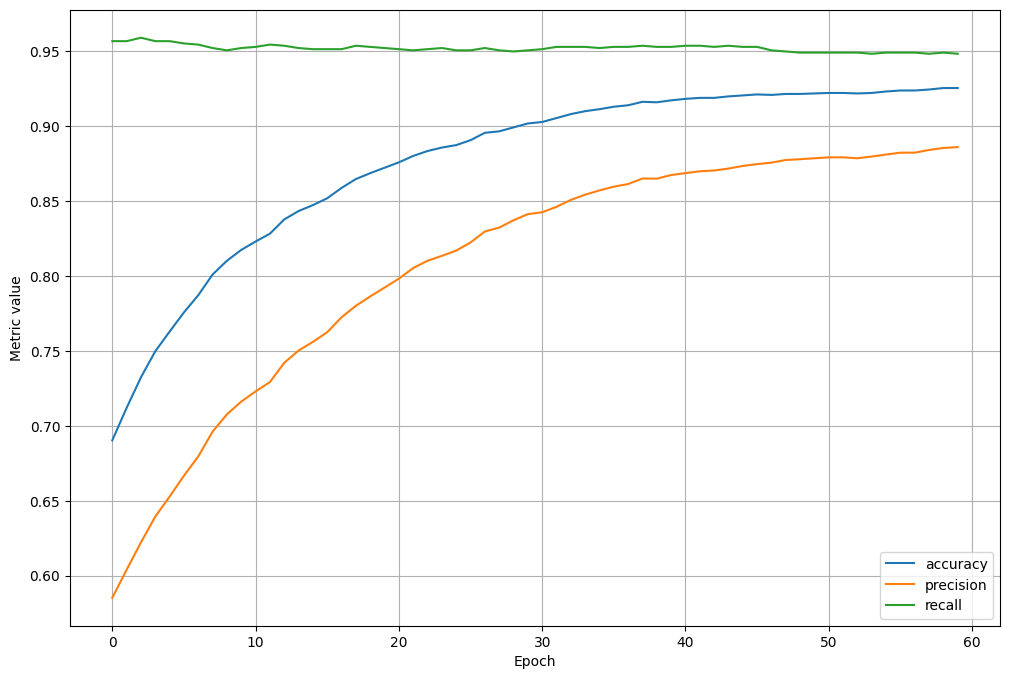

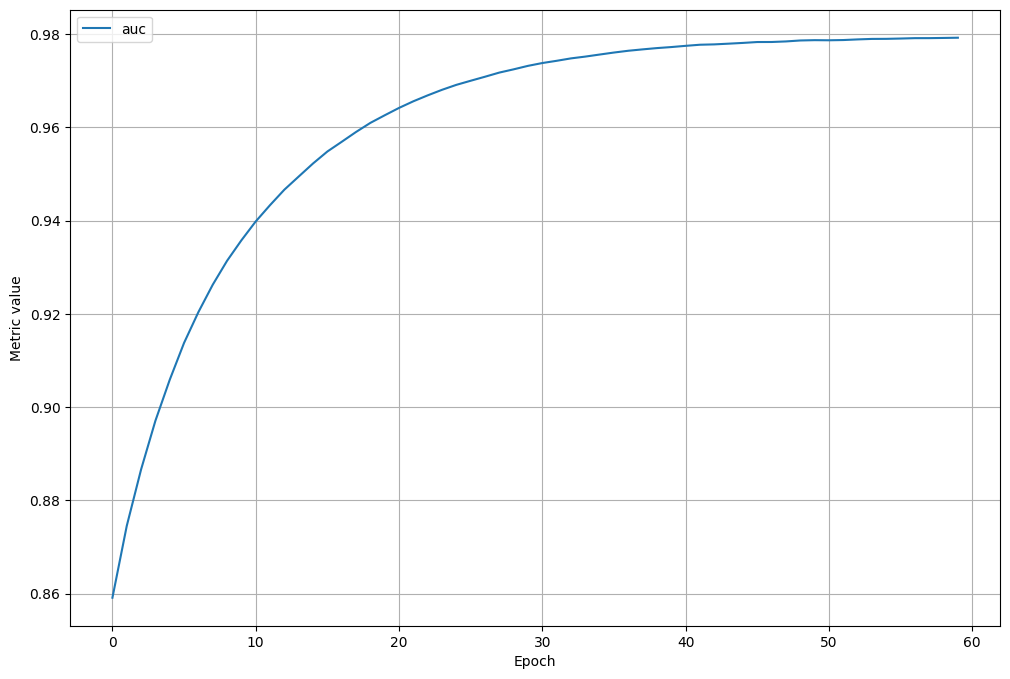

In [19]:
# Let's define our first experiment settings.
settings = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.35,
    input_features=input_features,
)

metrics = [
    keras.metrics.BinaryAccuracy(
        name='accuracy', threshold=settings.classification_threshold
    ),
    keras.metrics.Precision(
        name='precision', thresholds=settings.classification_threshold
    ),
    keras.metrics.Recall(
        name='recall', thresholds=settings.classification_threshold
    ),
    keras.metrics.AUC(num_thresholds=100, name='auc'),
]

# Establish the model's topography.
model = create_model(settings, metrics)

# Train the model on the training set.
experiment = train_model(
    'baseline', model, train_features, train_labels, settings
)

# Plot metrics vs. epochs
plot_experiment_metrics(experiment, ['accuracy', 'precision', 'recall'])
plot_experiment_metrics(experiment, ['auc'])

AUC is calculated across all possible thresholds (in practice in the code above, 100 thresholds), while accuracy, precision, and recall are calculated for only the specified threshold. For this reason they are shown separately above.

## Evaluate the model against the test set

At the end of model training, you ended up with a certain accuracy against the *training set*. Invoke the following code cell to determine your model's accuracy against the *test set*.

In [20]:
def evaluate_experiment(
    experiment: Experiment, test_dataset: pd.DataFrame, test_labels: np.array
) -> dict[str, float]:
  features = {
      feature_name: np.array(test_dataset[feature_name])
      for feature_name in experiment.settings.input_features
  }
  return experiment.model.evaluate(
      x=features,
      y=test_labels,
      batch_size=settings.batch_size,
      verbose=0, # Hide progress bar
      return_dict=True,
  )


def compare_train_test(experiment: Experiment, test_metrics: dict[str, float]):
  print('Comparing metrics between train and test:')
  for metric, test_value in test_metrics.items():
    print('------')
    print(f'Train {metric}: {experiment.get_final_metric_value(metric):.4f}')
    print(f'Test {metric}:  {test_value:.4f}')


# Evaluate test metrics
test_metrics = evaluate_experiment(experiment, test_features, test_labels)
compare_train_test(experiment, test_metrics)

Comparing metrics between train and test:
------
Train accuracy: 0.9252
Test accuracy:  0.9081
------
Train auc: 0.9793
Test auc:  0.9752
------
Train loss: 0.1844
Test loss:  0.1959
------
Train precision: 0.8858
Test precision:  0.8545
------
Train recall: 0.9481
Test recall:  0.9276


It appears that the model, which achieved ~92% accuracy on the training data, still shows an accuracy of about 90% on the test data. Can we do better? Let's train a model using all seven available features and compare the AUC.

In [22]:

# Features used to train the model on.
# Specify all features.
all_input_features = [
  'Eccentricity',
  'Major_Axis_Length',
  'Minor_Axis_Length',
  'Area',
  'Convex_Area',
  'Perimeter',
  'Extent',
]

## Train the full-featured model and calculate metrics

Epoch 1/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7970 - auc: 0.9552 - loss: 0.4140 - precision: 0.6862 - recall: 0.9728
Epoch 2/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7959 - auc: 0.9608 - loss: 0.3802 - precision: 0.6866 - recall: 0.9870
Epoch 3/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8199 - auc: 0.9652 - loss: 0.3545 - precision: 0.7140 - recall: 0.9860
Epoch 4/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8445 - auc: 0.9680 - loss: 0.3323 - precision: 0.7447 - recall: 0.9843
Epoch 5/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8614 - auc: 0.9700 - loss: 0.3131 - precision: 0.7679 - recall: 0.9817
Epoch 6/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8665 - auc: 0.9713 - loss: 0.2964 - precision: 0.7767 - recall: 0.9776
Epoch 7/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8771 - auc: 0.9723 - loss: 0.2819 - precision: 0.7929 - recall: 0.9757
Epoch 8/60
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - acc

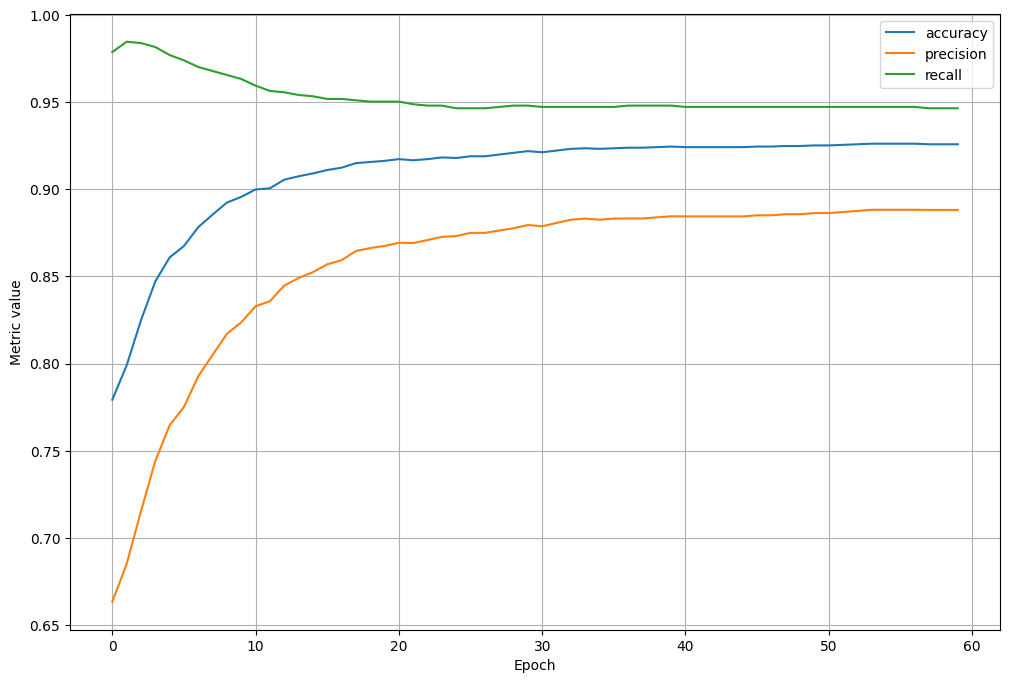

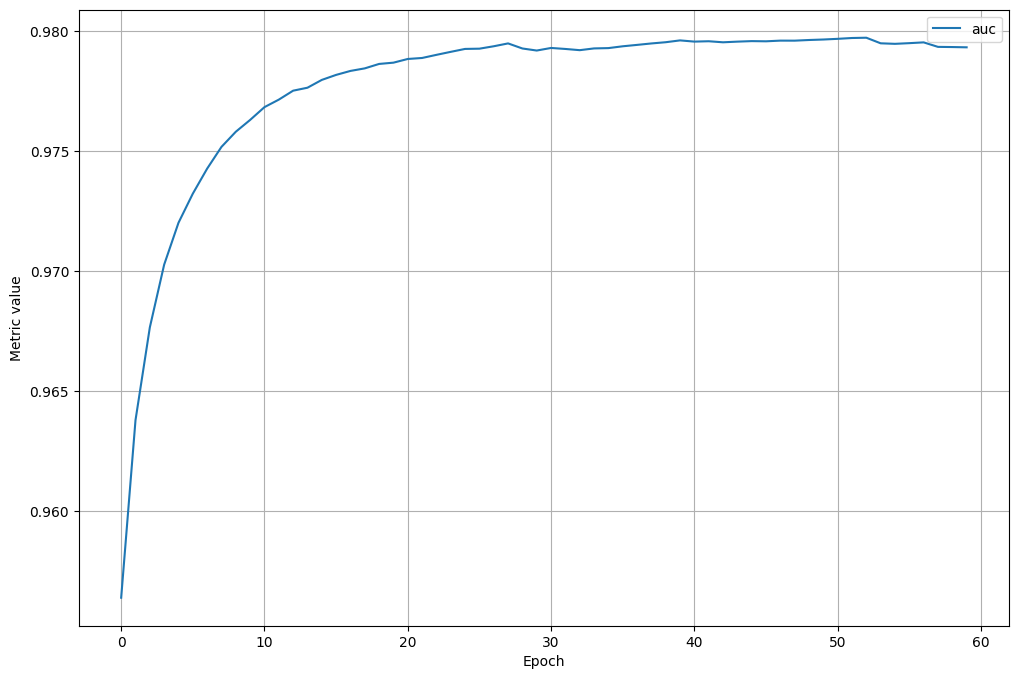

In [24]:
settings_all_features = ExperimentSettings(
    learning_rate=0.001,
    number_epochs=60,
    batch_size=100,
    classification_threshold=0.5,
    input_features=all_input_features,
)


# Establish the model's topography.
model_all_features = create_model(settings_all_features, metrics)

# Train the model on the training set.
experiment_all_features = train_model(
    'all features',
    model_all_features,
    train_features,
    train_labels,
    settings_all_features,
)

# Plot metrics vs. epochs
plot_experiment_metrics(
    experiment_all_features, ['accuracy', 'precision', 'recall']
)
plot_experiment_metrics(experiment_all_features, ['auc'])

## Evaluate full-featured model on test split

In [25]:
test_metrics_all_features = evaluate_experiment(
    experiment_all_features, test_features, test_labels
)
compare_train_test(experiment_all_features, test_metrics_all_features)

Comparing metrics between train and test:
------
Train accuracy: 0.9259
Test accuracy:  0.9055
------
Train auc: 0.9793
Test auc:  0.9761
------
Train loss: 0.1790
Test loss:  0.1900
------
Train precision: 0.8882
Test precision:  0.8537
------
Train recall: 0.9465
Test recall:  0.9211


This second model has very similar train and test metrics, suggesting it overfit less to the training data.